In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_theme(style="whitegrid")


# TensorNetwork class
class TensorNetwork:
    def __init__(self, graph, tensors):
        self.graph = graph
        self.tensors = tensors
        self.index_dims = {}
        self.index_to_tensors = {}

        for name, (tensor, indices) in tensors.items():
            for idx, dim in zip(indices, tensor.shape):
                if idx in self.index_dims:
                    assert self.index_dims[idx] == dim
                else:
                    self.index_dims[idx] = dim
                self.index_to_tensors.setdefault(idx, []).append((name, tensor, indices))

        self.col_of = {idx: i for i, idx in enumerate(self.index_dims)}
    
def naive_mc_estimate(network, num_samples=10000, Z_true=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    indices = list(network.index_dims)
    dims = [network.index_dims[i] for i in indices]
    all_vals = []

    for _ in range(num_samples):
        x = [np.random.randint(0, dim) for dim in dims]
        config = np.array(x).reshape(1, -1)
        val = evaluate_config(network, config)[0]
        all_vals.append(val)
    
    volume = np.prod(dims)
    mean_val = np.mean(all_vals)
    std_val = np.std(all_vals) / np.sqrt(num_samples)

    estimate = mean_val * volume
    error = std_val * volume

    print(f'Naive MC Estimate of Z: {estimate:.6f} ± {error:.6f}')
    if Z_true:
        relative_error = abs(estimate - Z_true) / abs(Z_true)
        print(f'Relative Error: {relative_error:.6%}')
    
    return estimate, error, all_vals


def evaluate_config(network, configs):
    result = np.ones(len(configs))
    for name, (tensor, inds) in network.tensors.items():
        keys = tuple(configs[:, network.col_of[i]] for i in inds)
        result *= tensor[keys]
    # return result
    return np.clip(result, 1e-30, None)  # avoid numerical issues with very small values


def update_edge(network, configs, idx, beta=1.0):
    dim = network.index_dims[idx]
    col = network.col_of[idx]
    n_chains = configs.shape[0]
    probs = np.ones((n_chains, dim))

    for _, tensor, inds in network.index_to_tensors[idx]:
        slc = [slice(None) if i == idx else configs[:, network.col_of[i]] for i in inds]
        arr_vals = tensor[tuple(slc)]
        if arr_vals.shape != (n_chains, dim):
            arr_vals = arr_vals.T
        arr_vals = np.clip(arr_vals, 1e-30, None)  # avoid numerical issues
        probs *= arr_vals ** beta

    row_sums = probs.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0  # avoid division by zero
    probs /= row_sums
    configs[:, col] = [np.random.choice(dim, p=probs[i]) for i in range(n_chains)]


def estimate_contraction(net, betas, iters=20000, burns=1900, n_chains=10, verbose=True):
    n_betas = len(betas)
    index_list = list(net.index_dims)
    n_sites = len(index_list)

    # configs = np.random.randint(0, 3, size=(n_chains, n_sites))

    # get a list of all edge-indices
    index_list = list(net.index_dims)

    # build an (n_chains × n_sites) array of random inits
    configs = np.empty((n_chains, len(index_list)), dtype=int)
    for j, idx in enumerate(index_list):
        d = net.index_dims[idx]
        configs[:, j] = np.random.randint(0, d, size=n_chains)
    
    np.random.shuffle(configs.T)
    logZ_sums = np.zeros(n_chains)
    logZ_trajs = [[] for _ in range(n_chains)]
    weights_by_beta = [[] for _ in range(n_betas - 1)]

    for step in range(1, n_betas):
        beta_prev, beta_curr = betas[step - 1], betas[step]
        delta_beta = beta_curr - beta_prev

        if verbose and (step % 10 == 0 or step == n_betas - 1):
            print(f'[{datetime.now().strftime("%H:%M:%S")}] beta step {step}/{n_betas - 1} ({beta_curr:.4f})')

        chain_weights = [[] for _ in range(n_chains)]

        for t in range(iters):
            idx = np.random.choice(index_list)
            update_edge(net, configs, idx, beta=beta_prev)

            if t >= burns:
                psi_vals = evaluate_config(net, configs)
                weights = np.where(psi_vals > 1e-30, psi_vals ** (delta_beta), 0.0)
                weights = np.clip(weights, 1e-30, None)  # avoid numerical issues
                for j in range(n_chains):
                    chain_weights[j].append(weights[j])

        for j in range(n_chains):
            w = chain_weights[j]
            mw = np.mean(w) if w else 0.0
            # log_rho = np.log(mw) if mw > 0 else -np.inf
            log_rho = np.logaddexp.reduce(np.log(w)) - np.log(len(w))
            logZ_sums[j] += log_rho
            logZ_trajs[j].append(logZ_sums[j])
            weights_by_beta[step - 1].append(np.asarray(w))

        if verbose:
            mean_log_rho = np.mean([np.log(np.mean(w)) if np.mean(w) > 0 else -np.inf for w in chain_weights])
            mean_w = np.mean([np.mean(w) for w in chain_weights])
            print(f"[beta={beta_curr:.3f}]  mean log rho = {mean_log_rho:+.3e}  | <w> mean = {mean_w:.4e}")

    log_size = np.sum(np.log(list(net.index_dims.values())))
    Z_ests = np.exp(logZ_sums + log_size)
    return Z_ests, logZ_trajs, weights_by_beta


def run_diagnostics(betas, logZ_trajectories, weights_by_beta, Z_ests, Z_true=None):
    n_chains = len(Z_ests)

    # logZ convergence
    plt.figure(figsize=(12, 3.8))
    for k, traj in enumerate(logZ_trajectories, 1):
        plt.plot(betas[1:], traj, label=f"chain {k}", alpha=0.8)
    plt.xlabel(r"$\beta$")
    plt.ylabel(r"$\log Z$")
    plt.title("log-Z convergence across chains")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # relative std dev of weights
    plt.figure(figsize=(12, 3.8))
    for k in range(n_chains):
        rel_sig = []
        for weights in weights_by_beta:
            w = weights[k]
            rel = np.std(w) / np.mean(w) if np.mean(w) > 0 else 0
            rel_sig.append(rel)
        plt.plot(betas[1:], rel_sig, label=f"chain {k+1}", alpha=0.8)
    plt.xlabel(r"$\beta$")
    plt.ylabel(r"rel $\sigma(w)$")
    plt.title("weight dispersion vs beta")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # log-weight variance
    log_var_per_beta = []
    for beta_weights in weights_by_beta:
        log_vars = [np.var(np.log(np.clip(w, 1e-12, None))) for w in beta_weights]
        log_var_per_beta.append(np.mean(log_vars))

    fig, ax = plt.subplots(figsize=(6.5, 4))
    sns.lineplot(x=betas[1:], y=log_var_per_beta, marker='o', ax=ax)
    ax.axhline(1.0, ls='--', color='gray', label='Variance Threshold')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'Variance of $\log w$')
    ax.set_title("Variance of Log-Weights vs Beta Step")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # error bars
    est_mean, est_std = np.mean(Z_ests), np.std(Z_ests)
    print(rf"\nFinal relative variance of $\hat Z$: {est_std / est_mean:.4e}")

    if Z_true is not None:
        rel_errs = [abs(z - Z_true) / abs(Z_true) for z in Z_ests]
        plt.figure(figsize=(5.5, 4))
        plt.bar(range(1, n_chains + 1), rel_errs)
        plt.xlabel("chain")
        plt.ylabel("rel error")
        plt.title("final relative error per chain")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"True  Z   : {Z_true:.6f}")
        print(f"Mean  Ẑ  : {est_mean:.6f}  ± {est_std:.6f}")
        print(f"Mean rel error: {np.mean(rel_errs):.8%}")


def run_multiple_chains(net, betas, dim=3, n_betas=300, iters=20000, burns=1900, n_chains=10, Z_true=None):
    print(f"Running {n_chains} AIS chains vectorized")
    Z_ests, logZ_trajectories, weights_by_beta = estimate_contraction(
        net, betas, iters, burns, n_chains=n_chains, verbose=True
    )

    run_diagnostics(betas, logZ_trajectories, weights_by_beta, Z_ests, Z_true=Z_true)
    return np.mean(Z_ests), np.std(Z_ests)

In [2]:
def test_trace_ABCD(dim=3,
                    n_betas=200,
                    n_chains=10,
                    iters=20000,
                    burns=10000):
    print("\n>>> Building 2x2 ring tensor network (Tr(ABCD))")

    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'), ('B', 'C'),
        ('C', 'D'), ('D', 'A'),
    ])

    tensors = {}
    index_order = {
        'A': ['i', 'j'],
        'B': ['j', 'k'],
        'C': ['k', 'l'],
        'D': ['l', 'i']
    }
    for node, inds in index_order.items():
        data = np.random.normal(loc=1.0, scale=0.01, size=(dim, dim)) + 1e-6
        tensors[node] = (data, inds)

    A, B, C, D = [tensors[k][0] for k in ['A', 'B', 'C', 'D']]
    TRUE_Z = np.einsum('ij,jk,kl,li->', A, B, C, D)
    print(f"True Z (Tr(ABCD)): {TRUE_Z:.6f}")

    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)

    print("\n>>> Running AIS estimation...")
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        Z_true=TRUE_Z
    )

    rel_error = abs(mean_Z - TRUE_Z) / abs(TRUE_Z)
    print("\n================== Final Summary ==================")
    print(f"True        Z  : {TRUE_Z:.12f}")
    print(f"Estimated   Z  : {mean_Z:.12f} ± {std_Z:.12f}")
    print(f"Relative Error : {rel_error:.12e}")
    print("====================================================")

# test_trace_ABCD()

In [3]:
def contract_tensor_network(graph, tensors):
    # build einsum expression from tensor network
    einsum_terms = []
    einsum_tensors = []
    index_map = {}
    chars = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')

    for _, (tensor, indices) in tensors.items():
        subs = []
        for idx in indices:
            if idx not in index_map:
                index_map[idx] = chars.pop(0)
            subs.append(index_map[idx])
        einsum_terms.append(''.join(subs))
        einsum_tensors.append(tensor)

    expr = ','.join(einsum_terms) + '->'
    return np.einsum(expr, *einsum_tensors)

def build_3x3_grid_test(dim=3, variance=0.1):
    # construct 3x3 grid tensor network
    np.random.seed(42)
    G = nx.Graph()
    tensors = {}
    grid_size = 3
    node_names = {(i, j): f"T{i}{j}" for i in range(grid_size) for j in range(grid_size)}

    def edge_index(i1, j1, i2, j2):
        return f"{i1}{j1}_{i2}{j2}"

    for i in range(grid_size):
        for j in range(grid_size):
            name = node_names[(i, j)]
            neighbors = []

            if j + 1 < grid_size:
                nbr = node_names[(i, j+1)]
                idx = edge_index(i, j, i, j+1)
                G.add_edge(name, nbr)
                neighbors.append(idx)
            if i + 1 < grid_size:
                nbr = node_names[(i+1, j)]
                idx = edge_index(i, j, i+1, j)
                G.add_edge(name, nbr)
                neighbors.append(idx)
            if j > 0:
                neighbors.append(edge_index(i, j-1, i, j))
            if i > 0:
                neighbors.append(edge_index(i-1, j, i, j))

            neighbors = sorted(neighbors)
            shape = (dim,) * len(neighbors)
            tensor = np.random.normal(loc=1.0, scale=variance, size=shape) + 1e-6
            tensor /= np.linalg.norm(tensor)  # normalize tensor
            # tensor = np.random.normal(loc=1.0, scale=0.01, size=(dim, dim)) + 1e-6
            tensors[name] = (tensor, neighbors)

    return G, tensors

def test_trace_3x3_grid(dim=3,
                        n_betas=100,
                        n_chains=5,
                        iters=20000,
                        burns=1900):
    # test ais on 3x3 grid tensor network using quadratic beta schedule
    print("\n>>> building 3x3 tensor network")
    G, tensors = build_3x3_grid_test(dim=dim)
    TRUE_Z = contract_tensor_network(G, tensors)
    print(f"true Z (exact contraction): {TRUE_Z:.6f}")

    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)

    print("\n>>> running ais with quadratic beta schedule")
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        Z_true=TRUE_Z
    )

    rel_error = abs(mean_Z - TRUE_Z) / abs(TRUE_Z)
    print("\n================== final summary ==================")
    print(f"true        Z  : {TRUE_Z:.12f}")
    print(f"estimated   Z  : {mean_Z:.12f} ± {std_Z:.12f}")
    print(f"relative error : {rel_error:.6e}")
    print("====================================================")

# run test
# test_trace_3x3_grid()

In [4]:
def run_variance_sweep(variances, dim=3, n_betas=100, n_chains=5, iters=20000, burns=1900, mc_samples=10000):
    rows = []
    for variance in variances:
        print(f"\n>>> running trial with tensor variance = {variance}")
        G, tensors = build_3x3_grid_test(dim=dim, variance=variance)
        TRUE_Z = contract_tensor_network(G, tensors)
        tn = TensorNetwork(G, tensors)
        betas = np.linspace(0, 1, n_betas)

        # run AIS
        Z_ais, _, _ = estimate_contraction(tn, betas, iters, burns, n_chains=n_chains, verbose=False)
        ais_mean, ais_std = np.mean(Z_ais), np.std(Z_ais)
        rel_ais = abs(ais_mean - TRUE_Z) / abs(TRUE_Z)

        # run naive MC
        mc_estimate, _, mc_values = naive_mc_estimate(tn, num_samples=mc_samples, Z_true=TRUE_Z, seed=42)
        mc_std = np.std(mc_values) / np.sqrt(len(mc_values))
        rel_mc = abs(mc_estimate - TRUE_Z) / abs(TRUE_Z)

        # save results
        rows.extend([
            {"variance": variance, "method": "AIS", "mean_Z": ais_mean, "std_Z": ais_std, "rel_error": rel_ais},
            {"variance": variance, "method": "NaiveMC", "mean_Z": mc_estimate, "std_Z": mc_std, "rel_error": rel_mc},
        ])

    return pd.DataFrame(rows)

def test_compare_ais_vs_naive_mc(dim=3,
                                 n_betas=100,
                                 n_chains=5,
                                 iters=20000,
                                 burns=1900,
                                 mc_samples=10000,
                                 variances=[0.001, 0.005, 0.01, 0.05, 0.1]):
    print("\n>>> building 3x3 tensor network for ais vs naive mc comparison")
    G, tensors = build_3x3_grid_test(dim=dim)
    TRUE_Z = contract_tensor_network(G, tensors)
    print(f'true Z (exact contraction): {TRUE_Z:.6f}')

    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)

    print('\n>>> running ais estimation')
    Z_ais, logZ_trajs, weights_by_beta = estimate_contraction(
        tn, betas, iters, burns, n_chains=n_chains, verbose=True
    )
    ais_mean, ais_std = np.mean(Z_ais), np.std(Z_ais)

    # run naive mc estimation
    print('\n>>> running naive mc estimation')
    mc_estimate, mc_error, mc_values = naive_mc_estimate(
        tn, num_samples=mc_samples, Z_true=TRUE_Z, seed=42
    )
    mc_std = np.std(mc_values) / np.sqrt(len(mc_values))
    mc_mean = mc_estimate

    # run performance sweep across tensor variances
    print('\n>>> running variance sweep for ais vs naive mc')
    results_df = run_variance_sweep(variances=variances,
                                        dim=dim,
                                        n_betas=n_betas,
                                        n_chains=n_chains,
                                        iters=iters,
                                        burns=burns,
                                        mc_samples=mc_samples)
    
    # plotting comparison
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    sns.set_theme(style="whitegrid")

    # log-z convergence plot
    for i, traj in enumerate(logZ_trajs):
        axs[0, 0].plot(betas[1:], traj, label=f'chain {i+1}', alpha=0.8)
    axs[0, 0].set_title('ais: log-z convergence')
    axs[0, 0].set_xlabel(r'$\beta$')
    axs[0, 0].set_ylabel(r'$\log Z$')

    # weight dispersion
    for i in range(n_chains):
        rel_std = [np.std(w[i]) / np.mean(w[i]) if np.mean(w[i]) > 0 else 0 for w in weights_by_beta]
        axs[0, 1].plot(betas[1:], rel_std, label=f'chain {i+1}', alpha=0.8)
    axs[0, 1].set_title('ais: relative std dev of weights vs beta')
    axs[0, 1].set_xlabel(r'$\beta$')
    axs[0, 1].set_ylabel(r'rel $\sigma(w)$')

    # naive mc histogram
    sns.histplot(mc_values, bins=50, kde=True, ax=axs[1, 0], color='blue', alpha=0.6)
    axs[1, 0].set_title('naive mc distribution of sampled $\psi(x)$')
    axs[1, 0].set_xlabel(r'$\psi(x)$ values')
    axs[1, 0].set_ylabel('frequency')

    # variance vs error (log-log plot)
    sns.lineplot(data=results_df, x='variance', y='rel_error', hue='method', ax=axs[1, 1], marker='o')
    axs[1, 1].set_title('ais vs naive mc across tensor difficulties')
    axs[1, 1].set_xlabel('tensor variance')
    axs[1, 1].set_ylabel('relative error')
    axs[1, 1].set_xscale('log')
    axs[1, 1].set_yscale('log')
    axs[1, 1].legend(title='method')
    axs[1, 1].grid(True, which='both', linestyle='--')

    plt.tight_layout()
    plt.show()

    print("\n================== final summary ==================")
    print(f"true Z               : {TRUE_Z:.6f}")
    print(f"ais estimate         : {ais_mean:.6f} ± {ais_std:.6f}")
    print(f"naive mc estimate    : {mc_mean:.6f} ± {mc_std:.6f}")
    print(f"relative error (ais) : {abs(ais_mean - TRUE_Z) / abs(TRUE_Z):.6%}")
    print(f"relative error (mc)  : {abs(mc_mean - TRUE_Z) / abs(TRUE_Z):.6%}")
    print("====================================================")

# test_compare_ais_vs_naive_mc(dim=3,
#                             n_betas=100,
#                             n_chains=5,
#                             iters=20000,
#                             burns=1900,
#                             mc_samples=10000)

<>:88: SyntaxWarning: invalid escape sequence '\p'
<>:88: SyntaxWarning: invalid escape sequence '\p'
/var/folders/nf/hy2hshms2_v1kl4rj3cq7q840000gn/T/ipykernel_67112/1081383734.py:88: SyntaxWarning: invalid escape sequence '\p'
  axs[1, 0].set_title('naive mc distribution of sampled $\psi(x)$')


In [5]:
def test_trace_diagonal_ABCD(dim=3,
                             n_betas=200,
                             n_chains=10,
                             iters=20000,
                             burns=10000):
    print("\n>>> Building 2x2 diagonal tensor network (Tr(ABCD))")

    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'), ('B', 'C'),
        ('C', 'D'), ('D', 'A'),
    ])

    tensors = {}
    index_order = {
        'A': ['i', 'j'],
        'B': ['j', 'k'],
        'C': ['k', 'l'],
        'D': ['l', 'i']
    }
    for node, inds in index_order.items():
        data = np.eye(dim) * 0.9 + np.ones((dim, dim)) * 0.1 / dim  # diagonal tensor with small noise
        data /= np.linalg.norm(data)  # normalize tensor
        tensors[node] = (data, inds)

    A, B, C, D = [tensors[k][0] for k in ['A', 'B', 'C', 'D']]
    TRUE_Z = np.einsum('ij,jk,kl,li->', A, B, C, D)
    print(f"True Z (Tr(ABCD)): {TRUE_Z:.6f}")

    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)

    print("\n>>> Running AIS estimation...")
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        Z_true=TRUE_Z
    )

    rel_error = abs(mean_Z - TRUE_Z) / abs(TRUE_Z)
    print("\n================== Final Summary ==================")
    print(f"True        Z  : {TRUE_Z:.12f}")
    print(f"Estimated   Z  : {mean_Z:.12f} ± {std_Z:.12f}")
    print(f"Relative Error : {rel_error:.12e}")
    print("====================================================")

# test_trace_diagonal_ABCD(dim=3,
#                           n_betas=200,
#                           n_chains=10,
#                           iters=20000,
#                           burns=10000)

In [6]:
def contract_tensor_network(graph, tensors):
    einsum_terms = []
    einsum_tensors = []
    index_map = {}
    chars = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')

    for _, (tensor, indices) in tensors.items():
        subs = []
        for idx in indices:
            if idx not in index_map:
                if not chars:
                    raise ValueError("ran out of characters for einsum indices")
                index_map[idx] = chars.pop(0)
            subs.append(index_map[idx])
        einsum_terms.append(''.join(subs))
        einsum_tensors.append(tensor)

    expr = ','.join(einsum_terms) + '->'
    return np.einsum(expr, *einsum_tensors, optimize='greedy')

def build_3x3_grid_diagonally_dominant(dim=3, noise_level=0.1):
    np.random.seed(42)
    G = nx.Graph()
    tensors = {}
    grid_size = 3
    node_names = {(i, j): f"T{i}{j}" for i in range(grid_size) for j in range(grid_size)}

    def edge_index(i1, j1, i2, j2):
        return "_".join(sorted([f"{i1}{j1}", f"{i2}{j2}"]))

    for i in range(grid_size):
        for j in range(grid_size):
            name = node_names[(i, j)]
            
            physical_neighbors = []
            if i > 0: physical_neighbors.append((i - 1, j))
            if i < grid_size - 1: physical_neighbors.append((i + 1, j))
            if j > 0: physical_neighbors.append((i, j - 1))
            if j < grid_size - 1: physical_neighbors.append((i, j + 1))

            indices = sorted([edge_index(i,j, ni,nj) for ni,nj in physical_neighbors])
            G.add_node(name)
            for ni, nj in physical_neighbors:
                 G.add_edge(name, node_names[(ni,nj)])
            
            shape = (dim,) * len(indices)
            rank = len(shape)

            diagonal_part = np.zeros(shape)
            for k in range(dim):
                idx = (k,) * rank 
                diagonal_part[idx] = 1.0

            noise_part = np.ones(shape)
            
            dominance_factor = 1.0 - noise_level
            tensor = diagonal_part * dominance_factor + noise_part * (noise_level / dim**rank)

            # tensor /= np.linalg.norm(tensor)
            tensors[name] = (tensor, indices)

    return G, tensors

# test ais on 3x3 diagonally-dominant grid tensor network
def test_trace_3x3_grid_dd(dim=3,
                           n_betas=200,
                           n_chains=10,
                           iters=20000,
                           burns=10000):
    print("\n>>> building 3x3 diagonally-dominant tensor network")
    G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
    
    print(">>> performing exact contraction (this may take a moment)...")
    TRUE_Z = contract_tensor_network(G, tensors)
    print(f"true z (exact contraction): {TRUE_Z:.12f}")

    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)**2

    print("\n>>> running ais estimation...")
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        Z_true=TRUE_Z,
    )

    rel_error = abs(mean_Z - TRUE_Z) / abs(TRUE_Z) if TRUE_Z != 0 else float('inf')
    print("\n================== final summary ==================")
    print(f"true        z  : {TRUE_Z:.12f}")
    print(f"estimated   z  : {mean_Z:.12f} ± {std_Z:.12f}")
    print(f"relative error : {rel_error:.6e}")
    print("====================================================")

# run test
# test_trace_3x3_grid_dd()

In [7]:
def test_rw_uniform_sample_efficiency(dim=3, n_betas=200, burns=2000, sample_sizes=[100, 500, 1000, 2000, 5000, 10000, 20000], target_error=0.01, n_chains=10):
    print('\n>>> building 2x2 diagonally-dominant tensor network for random walk vs uniform sampling efficiency test')
    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'), ('B', 'C'),
        ('C', 'D'), ('D', 'A'),
    ])

    tensors = {}
    index_order = {
        'A': ['i', 'j'],
        'B': ['j', 'k'],
        'C': ['k', 'l'],
        'D': ['l', 'i']
    }

    for node, inds in index_order.items():
        data = np.eye(dim) * 0.9 + np.ones((dim, dim)) * 0.1 / dim
        data /= np.linalg.norm(data)  # normalize tensor
        tensors[node] = (data, inds)
    
    A, B, C, D = [tensors[k][0] for k in ['A', 'B', 'C', 'D']]
    TRUE_Z = np.einsum('ij,jk,kl,li->', A, B, C, D)
    print(f"True Z (Tr(ABCD)): {TRUE_Z:.6f}")
    
    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)
    results = {'samples': [], 'Uniform': [], 'AIS': []}

    for n_samples in sample_sizes:
        iters = n_samples
        burn_in = max(int(iters * 0.1), 50)  # ensure burns is at least 10% of samples
        print(f'\n --- Testing with {n_samples} samples --- ')

        # uniform sampling (no walkers)
        est_u, std_u, _ = naive_mc_estimate(tn, num_samples=iters*n_chains, Z_true=TRUE_Z, seed=42)
        rel_error_u = abs(est_u - TRUE_Z) / abs(TRUE_Z) if TRUE_Z != 0 else float('inf')

        # random walk-AIS sampling
        est_rw, std_rw = run_multiple_chains(
            tn, betas,
            n_chains=n_chains,
            iters=n_samples,
            burns=burn_in,
            Z_true=TRUE_Z
        )
        rel_error_rw = abs(est_rw - TRUE_Z) / abs(TRUE_Z) if TRUE_Z != 0 else float('inf')

        results['samples'].append(n_samples)
        results['Uniform'].append(rel_error_u)
        results['AIS'].append(rel_error_rw)

    df = pd.DataFrame({
        'Samples per Chain': results['samples'] * 2,
        'Relative Error': results['Uniform'] + results['AIS'],
        'Method': ['Uniform'] * len(results['samples']) + ['AIS (Random Walk)'] * len(results['samples'])
    })

    sns.set_theme(style='whitegrid', font_scale=1.3)
    plt.figure(figsize=(8, 5))
    palette = sns.color_palette('tab10', 2)
    sns.lineplot(
        data=df,
        x='Samples per Chain',
        y='Relative Error',
        hue='Method',
        style='Method',
        markers=True,
        dashes=False,
        lw=2.3,
        markersize=9,
        marker='o',
        palette=palette
    )
    plt.yscale('log')
    plt.ylabel('Relative Error (log)')
    plt.title('Sample Efficiency: Uniform vs AIS (Random Walk)')
    plt.legend(title='Sampling Method')
    plt.tight_layout()
    plt.show()

# test_rw_uniform_sample_efficiency(
#     dim=3,
#     n_betas=200,
#     burns=2000,
#     sample_sizes=[100, 500, 1000, 2000, 5000, 10000, 20000],
#     target_error=0.01,
#     n_chains=10
# )

In [8]:
def test_rw_uniform_sample_efficiency_local(
    dim=3,
    beta_prev=0.4,
    beta_next=0.41,
    sample_sizes=[100, 500, 1000, 2000, 5000, 10000],
    n_chains=10
):
    print('\n>>> Building 2x2 diagonally-dominant tensor network for local sampling test (RW vs Uniform at single β step)')

    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'), ('B', 'C'),
        ('C', 'D'), ('D', 'A'),
    ])

    tensors = {}
    index_order = {
        'A': ['i', 'j'],
        'B': ['j', 'k'],
        'C': ['k', 'l'],
        'D': ['l', 'i']
    }

    for node, inds in index_order.items():
        data = np.eye(dim) * 0.9 + np.ones((dim, dim)) * 0.1 / dim
        data /= np.linalg.norm(data)  # normalize tensor
        tensors[node] = (data, inds)

    tn = TensorNetwork(G, tensors)
    TRUE_Z = np.einsum('ij,jk,kl,li->', *[tensors[k][0] for k in ['A', 'B', 'C', 'D']])
    print(f">>> True Z (Tr(ABCD)): {TRUE_Z:.6f}")

    delta_beta = beta_next - beta_prev
    print(f">>> Evaluating ratio at beta step {int(beta_prev * 200)}: β={beta_prev:.4f} → {beta_next:.4f}, Δβ={delta_beta:.4f}")

    results = {
        'samples': [],
        'Uniform_relerr': [],
        'Uniform_sem': [],
        'AIS_relerr': [],
        'AIS_sem': []
    }

    for n_samples in sample_sizes:
        burn_in = max(int(n_samples * 0.1), 50)
        print(f'\n --- Testing with {n_samples} samples --- ')

        psi_vals = []
        for _ in range(n_samples * n_chains):
            x = [np.random.randint(0, dim) for _ in tn.index_dims]
            config = np.array(x).reshape(1, -1)
            psi = evaluate_config(tn, config)[0]
            psi_vals.append(psi)

        psi_vals = np.clip(np.array(psi_vals), 1e-30, None)
        weights_uniform = psi_vals ** delta_beta
        estimate_u = np.mean(weights_uniform)
        std_u = np.std(weights_uniform, ddof=1) / np.sqrt(len(weights_uniform))  # SEM
        rel_error_u = std_u / estimate_u
        print(f"Uniform Estimate of ratio: {estimate_u:.6f} +/- {std_u:.6f} | Relative Error: {rel_error_u:.6%}")

        n_total_samples = n_chains  # one sample per chain (final config)
        configs = np.random.randint(0, dim, size=(n_chains, len(tn.index_dims)))

        for _ in range(burn_in + n_samples):
            idx = np.random.choice(list(tn.index_dims))
            update_edge(tn, configs, idx, beta=beta_prev)

        # take final configs after walk
        psi_vals_rw = evaluate_config(tn, configs)
        weights_rw = np.clip(psi_vals_rw, 1e-30, None) ** delta_beta

        estimate_rw = np.mean(weights_rw)
        std_rw = np.std(weights_rw, ddof=1) / np.sqrt(n_total_samples)  # SEM
        rel_error_rw = std_rw / estimate_rw
        print(f"Random Walk Estimate of ratio: {estimate_rw:.6f} +/- {std_rw:.6f} | Relative Error: {rel_error_rw:.10%}")

        results['samples'].append(n_samples)
        results['Uniform_relerr'].append(rel_error_u)
        results['Uniform_sem'].append(std_u)
        results['AIS_relerr'].append(rel_error_rw)
        results['AIS_sem'].append(std_rw)

    df = pd.DataFrame({
        'Samples per Chain': results['samples'] * 2,
        'Relative Error': results['Uniform_relerr'] + results['AIS_relerr'],
        'SEM': results['Uniform_sem'] + results['AIS_sem'],
        'Method': ['Uniform'] * len(results['samples']) + ['AIS (Random Walk)'] * len(results['samples'])
    })

    sns.set_theme(style='whitegrid', font_scale=1.35)
    plt.figure(figsize=(8, 5))

    palette = sns.color_palette('tab10', 2)
    ax = sns.lineplot(
        data=df,
        x='Samples per Chain',
        y='Relative Error',
        hue='Method',
        style='Method',
        markers=True,
        dashes=False,
        lw=2.5,
        markersize=9,
        palette=palette,
        err_style=None
    )

    for method in ['Uniform', 'AIS (Random Walk)']:
        subset = df[df['Method'] == method]
        plt.errorbar(
            subset['Samples per Chain'],
            subset['Relative Error'],
            yerr=subset['SEM'],
            fmt='none',
            capsize=4,
            elinewidth=1.5,
            capthick=1.2,
            color=palette[0] if method == 'Uniform' else palette[1]
        )

    plt.yscale('log')
    plt.ylabel('Relative Error (log)')
    plt.title(f'Sample Efficiency at beta={beta_prev:.2f} to beta={beta_next:.2f}')
    plt.legend(title='Sampling Method')
    plt.tight_layout()
    plt.show()


# Run the experiment
# test_rw_uniform_sample_efficiency_local(
#     dim=3,
#     beta_prev=0.8,
#     beta_next=0.81,
#     sample_sizes=[100, 500, 1000, 2000, 5000, 10000],
#     n_chains=10
# )

In [9]:
def test_rw_vs_uniform_across_betas(
    dim=3,
    n_chains=10,
    n_samples=5000,
    beta_steps=np.linspace(0, 1, 101)  # steps of 0.01
):
    print('\n>>> Building 2x2 diagonally-dominant tensor network for full β sweep test')

    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'), ('B', 'C'),
        ('C', 'D'), ('D', 'A'),
    ])

    tensors = {}
    index_order = {
        'A': ['i', 'j'],
        'B': ['j', 'k'],
        'C': ['k', 'l'],
        'D': ['l', 'i']
    }

    for node, inds in index_order.items():
        data = np.eye(dim) * 0.9 + np.ones((dim, dim)) * 0.1 / dim
        data /= np.linalg.norm(data)  # normalize tensor
        tensors[node] = (data, inds)

    tn = TensorNetwork(G, tensors)
    TRUE_Z = np.einsum('ij,jk,kl,li->', *[tensors[k][0] for k in ['A', 'B', 'C', 'D']])
    print(f">>> True Z (Tr(ABCD)): {TRUE_Z:.6f}")

    results = {
        'beta': [],
        'Uniform_relerr': [],
        'AIS_relerr': [],
    }

    for i in range(len(beta_steps) - 1):
        beta_prev = beta_steps[i]
        beta_next = beta_steps[i + 1]
        delta_beta = beta_next - beta_prev

        print(f"\n>>> Beta step {i+1}/{len(beta_steps)-1}: β={beta_prev:.2f} → {beta_next:.2f} (Δβ={delta_beta:.4f})")

        burn_in = max(int(n_samples * 0.1), 50)

        psi_vals = []
        for _ in range(n_samples * n_chains):
            x = [np.random.randint(0, dim) for _ in tn.index_dims]
            config = np.array(x).reshape(1, -1)
            psi = evaluate_config(tn, config)[0]
            psi_vals.append(psi)

        psi_vals = np.clip(np.array(psi_vals), 1e-30, None)
        weights_uniform = psi_vals ** delta_beta
        estimate_u = np.mean(weights_uniform)
        std_u = np.std(weights_uniform, ddof=1) / np.sqrt(len(weights_uniform))  # SEM
        rel_error_u = std_u / estimate_u
        print(f"Uniform Estimate: {estimate_u:.6f} +/- {std_u:.6f} | Rel Error: {rel_error_u:.6%}")

        index_list = list(tn.index_dims)
        n_sites = len(index_list)

        configs = np.tile(np.arange(dim), (n_chains, int(np.ceil(n_sites / dim))))[:, :n_sites]
        np.random.shuffle(configs.T)

        for t in range(burn_in):
            idx = np.random.choice(index_list)
            update_edge(tn, configs, idx, beta=beta_prev)

        weights = []
        for _ in range(n_samples):
            for idx in index_list:
                update_edge(tn, configs, idx, beta=beta_prev)

            psi_vals = evaluate_config(tn, configs)
            w = np.clip(psi_vals, 1e-30, None) ** delta_beta
            weights.append(w)

        weights = np.array(weights)  # shape (n_samples, n_chains)
        weights_mean = weights.mean(axis=0)  # mean over samples for each chain

        estimate_rw = np.mean(weights_mean)
        std_rw = np.std(weights_mean, ddof=1) / np.sqrt(n_chains)  # SEM over chains
        rel_error_rw = std_rw / estimate_rw
        print(f"Random Walk Estimate: {estimate_rw:.6f} +/- {std_rw:.6f} | Rel Error: {rel_error_rw:.6%}")

        results['beta'].append(beta_prev)
        results['Uniform_relerr'].append(rel_error_u)
        results['AIS_relerr'].append(rel_error_rw)

    df = pd.DataFrame({
        'Beta': results['beta'] * 2,
        'Relative Error': results['Uniform_relerr'] + results['AIS_relerr'],
        'Method': ['Uniform'] * len(results['beta']) + ['AIS (Random Walk)'] * len(results['beta'])
    })

    sns.set_theme(style='whitegrid', font_scale=1.3)
    plt.figure(figsize=(9, 5))
    sns.lineplot(
        data=df,
        x='Beta',
        y='Relative Error',
        hue='Method',
        style='Method',
        markers=True,
        dashes=False,
        lw=2.5,
        markersize=8
    )
    plt.yscale('log')
    plt.xlabel('Beta')
    plt.ylabel('Relative Error (log)')
    plt.title(f'Relative Error vs Beta | Samples={n_samples} per chain')
    plt.legend(title='Sampling Method')
    plt.tight_layout()
    plt.show()


# run
# test_rw_vs_uniform_across_betas(
#     dim=3,
#     n_chains=10,
#     n_samples=5000,
#     beta_steps=np.linspace(0, 1, 101)
# )

In [10]:
def test_rw_vs_uniform_across_betas_3x3(
    dim=3,
    n_chains=10,
    n_samples=5000,
    beta_steps=np.linspace(0, 1, 101)  # steps of 0.01
):
    print(r'\n>>> Building 3x3 diagonally-dominant tensor network for full $\beta$ sweep test')

    G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
    tn = TensorNetwork(G, tensors)

    TRUE_Z = contract_tensor_network(G, tensors)
    print(f">>> True Z (exact contraction): {TRUE_Z:.6f}")

    results = {
        'beta': [],
        'Uniform_relerr': [],
        'AIS_relerr': [],
    }

    for i in range(len(beta_steps) - 1):
        beta_prev = beta_steps[i]
        beta_next = beta_steps[i + 1]
        delta_beta = beta_next - beta_prev

        print(f"\n>>> Beta step {i+1}/{len(beta_steps)-1}: β={beta_prev:.2f} → {beta_next:.2f} (Δβ={delta_beta:.4f})")

        burn_in = max(int(n_samples * 0.1), 50)

        psi_vals = []
        for _ in range(n_samples * n_chains):
            x = [np.random.randint(0, dim) for _ in tn.index_dims]
            config = np.array(x).reshape(1, -1)
            psi = evaluate_config(tn, config)[0]
            psi_vals.append(psi)

        psi_vals = np.clip(np.array(psi_vals), 1e-30, None)
        weights_uniform = psi_vals ** delta_beta
        estimate_u = np.mean(weights_uniform)
        std_u = np.std(weights_uniform, ddof=1) / np.sqrt(len(weights_uniform))  # SEM
        rel_error_u = std_u / estimate_u
        print(f"Uniform Estimate: {estimate_u:.6f} +/- {std_u:.6f} | Rel Error: {rel_error_u:.6%}")

        index_list = list(tn.index_dims)
        n_sites = len(index_list)

        configs = np.tile(np.arange(dim), (n_chains, int(np.ceil(n_sites / dim))))[:, :n_sites]
        np.random.shuffle(configs.T)

        for t in range(burn_in):
            idx = np.random.choice(index_list)
            update_edge(tn, configs, idx, beta=beta_prev)

        weights = []
        for _ in range(n_samples):
            for idx in index_list:
                update_edge(tn, configs, idx, beta=beta_prev)

            psi_vals = evaluate_config(tn, configs)
            w = np.clip(psi_vals, 1e-30, None) ** delta_beta
            weights.append(w)

        weights = np.array(weights)  # shape (n_samples, n_chains)
        weights_mean = weights.mean(axis=0)  # mean over samples for each chain

        estimate_rw = np.mean(weights_mean)
        std_rw = np.std(weights_mean, ddof=1) / np.sqrt(n_chains)  # SEM over chains
        rel_error_rw = std_rw / estimate_rw
        print(f"Random Walk Estimate: {estimate_rw:.6f} +/- {std_rw:.6f} | Rel Error: {rel_error_rw:.6%}")

        results['beta'].append(beta_prev)
        results['Uniform_relerr'].append(rel_error_u)
        results['AIS_relerr'].append(rel_error_rw)

    df = pd.DataFrame({
        'Beta': results['beta'] * 2,
        'Relative Error': results['Uniform_relerr'] + results['AIS_relerr'],
        'Method': ['Uniform'] * len(results['beta']) + ['AIS (Random Walk)'] * len(results['beta'])
    })

    sns.set_theme(style='whitegrid', font_scale=1.3)
    plt.figure(figsize=(9, 5))
    sns.lineplot(
        data=df,
        x='Beta',
        y='Relative Error',
        hue='Method',
        style='Method',
        markers=True,
        dashes=False,
        lw=2.5,
        markersize=8
    )
    plt.yscale('log')
    plt.xlabel('Beta')
    plt.ylabel('Relative Error (log)')
    plt.title(f'Relative Error vs Beta | 3x3 Grid | Samples={n_samples} per chain')
    plt.legend(title='Sampling Method')
    plt.tight_layout()
    plt.show()


# run test
# test_rw_vs_uniform_across_betas_3x3(
#     dim=3,
#     n_chains=10,
#     n_samples=5000,
#     beta_steps=np.linspace(0, 1, 101)
# )

In [11]:
def test_rw_vs_uniform_efficiency_3x3(
    dim=3,
    sample_sizes=[100, 500, 1000, 2000, 5000, 10000, 20000, 50000],
    n_chains=10
):
    print("\n>>> Building 3x3 diagonally-dominant tensor network for efficiency test")

    G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
    tn = TensorNetwork(G, tensors)

    TRUE_Z = contract_tensor_network(G, tensors)
    print(f">>> True Z (exact contraction): {TRUE_Z:.6f}")

    results = {
        'Samples': [],
        'Method': [],
        'Relative Error': []
    }

    for n_samples in sample_sizes:
        burn_in = max(int(n_samples * 0.1), 50)
        print(f'\n --- Testing with {n_samples} samples --- ')

        psi_vals = []
        for _ in range(n_samples * n_chains):
            x = [np.random.randint(0, dim) for _ in tn.index_dims]
            config = np.array(x).reshape(1, -1)
            psi = evaluate_config(tn, config)[0]
            psi_vals.append(psi)

        psi_vals = np.clip(np.array(psi_vals), 1e-30, None)
        volume = np.prod([dim] * len(tn.index_dims))
        estimate_u = np.mean(psi_vals) * volume
        std_u = (np.std(psi_vals, ddof=1) / np.sqrt(len(psi_vals))) * volume
        rel_error_u = std_u / estimate_u
        print(f"Naive MC Estimate: {estimate_u:.6f} +/- {std_u:.6f} | Rel Error: {rel_error_u:.6%}")

        results['Samples'].append(n_samples)
        results['Method'].append('NaiveMC')
        results['Relative Error'].append(rel_error_u)

        Z_rw, _, _ = estimate_contraction(
            tn,
            betas=np.linspace(0, 1, 200),
            iters=n_samples,
            burns=burn_in,
            n_chains=n_chains,
            verbose=False
        )
        estimate_rw = np.mean(Z_rw)
        std_rw = np.std(Z_rw, ddof=1) / np.sqrt(n_chains)
        rel_error_rw = std_rw / estimate_rw
        print(f"AIS Estimate: {estimate_rw:.6f} +/- {std_rw:.6f} | Rel Error: {rel_error_rw:.6%}")

        results['Samples'].append(n_samples)
        results['Method'].append('AIS')
        results['Relative Error'].append(rel_error_rw)

    df = pd.DataFrame(results)

    sns.set_theme(style='whitegrid', font_scale=1.35)
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df,
        x='Samples',
        y='Relative Error',
        hue='Method',
        marker='o',
        lw=2.5
    )
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Samples (log)')
    plt.ylabel('Relative Error (log)')
    plt.title('Relative Error vs Samples | 3x3 Diagonal-Dominant Grid')
    plt.tight_layout()
    plt.show()


# run the test
# test_rw_vs_uniform_efficiency_3x3(
#     dim=3,
#     sample_sizes=[100, 500, 1000, 2000, 5000, 10000, 20000, 50000],
#     n_chains=10
# )

In [12]:
def test_scaling_vs_dimension_3x3(
    dims=[2, 3, 4, 5, 6, 7, 8],
    n_chains=10,
    n_betas=50,
    total_updates=40_000
):
    print("\n>>> Running AIS and Naive MC scaling test over tensor dimensions")

    results = {
        'Dimension': [],
        'Method': [],
        'Relative Error': []
    }

    for dim in dims:
        print(f"\n>>> Building 3x3 diagonally-dominant tensor network with dim={dim}")
        
        G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
        tn = TensorNetwork(G, tensors)
        TRUE_Z = contract_tensor_network(G, tensors)
        print(f">>> True Z (exact contraction): {TRUE_Z:.6f}")

        psi_vals = []
        for _ in range(total_updates):
            x = [np.random.randint(0, tn.index_dims[idx]) for idx in tn.index_dims]
            config = np.array(x).reshape(1, -1)
            psi = evaluate_config(tn, config)[0]
            psi_vals.append(psi)

        psi_vals = np.clip(np.array(psi_vals), 1e-30, None)
        estimate_u = np.mean(psi_vals)
        std_u = np.std(psi_vals, ddof=1) / np.sqrt(len(psi_vals))
        rel_error_u = std_u / estimate_u
        print(f"Naive MC Estimate: {estimate_u:.6f} +/- {std_u:.6f} | Rel Error: {rel_error_u:.6%}")

        results['Dimension'].append(dim)
        results['Method'].append('NaiveMC')
        results['Relative Error'].append(rel_error_u)

        iters = max(total_updates // (n_betas - 1), 1)
        burn_in = max(int(iters * 0.1), 20)
        betas = np.linspace(0, 1, n_betas)

        Z_rw, _, _ = estimate_contraction(
            tn,
            betas=betas,
            iters=iters,
            burns=burn_in,
            n_chains=n_chains,
            verbose=False
        )

        estimate_rw = np.mean(Z_rw)
        std_rw = np.std(Z_rw, ddof=1) / np.sqrt(n_chains)
        rel_error_rw = std_rw / estimate_rw
        print(f"AIS Estimate: {estimate_rw:.6f} +/- {std_rw:.6f} | Rel Error: {rel_error_rw:.6%}")

        results['Dimension'].append(dim)
        results['Method'].append('AIS')
        results['Relative Error'].append(rel_error_rw)

    # ================= Plot =================
    df = pd.DataFrame(results)

    sns.set_theme(style='whitegrid', font_scale=1.35)
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df,
        x='Dimension',
        y='Relative Error',
        hue='Method',
        marker='o',
        lw=2.5
    )
    plt.yscale('log')
    plt.xlabel('Tensor Dimension')
    plt.ylabel('Relative Error (log)')
    plt.title('Relative Error vs Tensor Dimension | 3x3 Diagonal-Dominant Grid')
    plt.tight_layout()
    plt.show()

# test_scaling_vs_dimension_3x3()

In [13]:
def contract_at_beta(graph, tensors, beta):
    """
    Raise each tensor entry to the power `beta`,
    then contract with your existing einsum-based function.
    """
    tempered = {}
    for name, (T, inds) in tensors.items():
        T2 = np.clip(T, 1e-30, None) ** beta
        tempered[name] = (T2, inds)
    return contract_tensor_network(graph, tempered)

def test_ais_error_vs_samples_walk_duration(
    dim=3,
    beta_prev=0.79,
    beta_curr=0.80,
    walk_durations=[0, 100, 10_000],
    sample_sizes=[50, 100, 150, 200, 500],
    n_trials=20
):
    delta = beta_curr - beta_prev

    G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
    tn = TensorNetwork(G, tensors)

    Z_prev = contract_at_beta(G, tensors, beta_prev)
    Z_curr = contract_at_beta(G, tensors, beta_curr)
    true_ratio = Z_curr / Z_prev
    formatted_delta = f'{delta:.4f}'
    formatted_ratio = f'{true_ratio:.6f}'
    print(r">>> True single-step ratio: " + formatted_ratio + r"  ($\Delta \beta$ = " + formatted_delta + ")\n")

    results = {'Chains': [], 'Walk': [], 'MeanErr': [], 'StdErr': []}

    for walk in walk_durations:
        for N in sample_sizes:
            errs = []
            for _ in range(n_trials):
                weights = []
                for _ in range(N):
                    config = np.array([
                        np.random.randint(0, tn.index_dims[idx])
                        for idx in tn.index_dims
                    ]).reshape(1, -1)

                    for _ in range(walk):
                        idx = np.random.choice(list(tn.index_dims))
                        update_edge(tn, config, idx, beta=beta_prev)

                    ψ = evaluate_config(tn, config)[0]
                    weights.append(ψ**delta)

                ρ_hat = np.mean(weights)
                errs.append(abs(ρ_hat - true_ratio) / abs(true_ratio))

            mean_err = np.mean(errs)
            se     = np.std(errs, ddof=1) / np.sqrt(n_trials)
            print(f"Walk={walk:6d}, Chains={N:4d} --> Error={mean_err:.2%} ±{se:.2%}")

            results['Chains'].append(N)
            results['Walk'].append(f"{walk} steps")
            results['MeanErr'].append(mean_err)
            results['StdErr'].append(se)

    df = pd.DataFrame(results)
    sns.set_theme(style="whitegrid", font_scale=1.3)
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=df, x="Chains", y="MeanErr",
        hue="Walk", style="Walk",
        markers=True, dashes=False
    )
    # errorbars
    palette = sns.color_palette("tab10")
    for i, walk in enumerate(walk_durations):
        sub = df[df['Walk']==f"{walk} steps"]
        plt.errorbar(
            sub['Chains'], sub['MeanErr'],
            yerr=sub['StdErr'], fmt='none',
            capsize=3, color=palette[i]
        )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Number of Chains (N)")
    plt.ylabel("Mean Relative Error")
    label = f"{delta:.4f}"
    plt.title(r"AIS ratio error vs. N at $\Delta \beta$ = " + label)
    plt.tight_layout()
    plt.show()

# test_ais_error_vs_samples_walk_duration()

In [14]:
def test_error_vs_samples_with_fixed_chains(
    dim=3,
    beta_prev=0.79,
    beta_curr=0.80,
    walk_durations=[0, 100, 10_000],
    sample_sizes=[5, 10, 20, 50, 100, 200],
    n_chains=10,
    n_trials=20,
):
    delta_beta = beta_curr - beta_prev

    G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
    tn = TensorNetwork(G, tensors)
    Z_prev = contract_at_beta(G, tensors, beta_prev)
    Z_curr = contract_at_beta(G, tensors, beta_curr)
    true_ratio = Z_curr / Z_prev

    print(f">>> True single-step ratio: {true_ratio:.6f}  (Δβ={delta_beta:.4f})\n")

    results = {'SamplesPerChain': [], 'Walk': [], 'MeanErr': [], 'StdErr': []}

    for walk in walk_durations:
        for S in sample_sizes:
            trial_errs = []
            for _ in range(n_trials):
                # collect all weights across all chains and samples
                weights = []
                for _ in range(n_chains):
                    for _ in range(S):
                        config = np.array([
                            np.random.randint(0, tn.index_dims[idx])
                            for idx in tn.index_dims
                        ]).reshape(1, -1)
                        for _ in range(walk):
                            idx = np.random.choice(list(tn.index_dims))
                            update_edge(tn, config, idx, beta=beta_prev)

                        ψ = evaluate_config(tn, config)[0]
                        weights.append(ψ ** delta_beta)

                ρ_hat = np.mean(weights)
                trial_errs.append(abs(ρ_hat - true_ratio) / abs(true_ratio))

            mean_err = np.mean(trial_errs)
            se      = np.std(trial_errs, ddof=1) / np.sqrt(n_trials)
            print(f"Walk={walk:6d}, Samples/Chain={S:4d} → Error={mean_err:.2%} ±{se:.2%}")

            results['SamplesPerChain'].append(S)
            results['Walk'].append(f"{walk} steps")
            results['MeanErr'].append(mean_err)
            results['StdErr'].append(se)

    #error vs. samples per chain
    import pandas as pd
    df = pd.DataFrame(results)
    sns.set_theme(style="whitegrid", font_scale=1.3)
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=df, x="SamplesPerChain", y="MeanErr",
        hue="Walk", style="Walk",
        markers=True, dashes=False
    )
    palette = sns.color_palette("tab10")
    for i, walk in enumerate(walk_durations):
        sub = df[df['Walk']==f"{walk} steps"]
        plt.errorbar(
            sub['SamplesPerChain'], sub['MeanErr'],
            yerr=sub['StdErr'], fmt='none',
            capsize=3, color=palette[i]
        )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Samples per Chain")
    plt.ylabel("Mean Relative Error")
    plt.title(f"AIS ratio error vs. samples per chain @ Δβ={delta_beta:.4f}")
    plt.tight_layout()
    plt.show()

# test_error_vs_samples_with_fixed_chains()

>>> True single-step ratio: 0.976089  (Δβ=0.0100)

Walk=     0, Samples/Chain=     5 → Error=0.21% ±0.06%
Walk=     0, Samples/Chain=    10 → Error=0.16% ±0.06%
Walk=     0, Samples/Chain=    25 → Error=0.09% ±0.02%
Walk=     0, Samples/Chain=    50 → Error=0.08% ±0.02%
Walk=   100, Samples/Chain=     5 → Error=0.11% ±0.03%
Walk=   100, Samples/Chain=    10 → Error=0.09% ±0.02%
Walk=   100, Samples/Chain=    25 → Error=0.07% ±0.02%
Walk=   100, Samples/Chain=    50 → Error=0.04% ±0.01%
Walk= 10000, Samples/Chain=     5 → Error=0.12% ±0.02%
Walk= 10000, Samples/Chain=    10 → Error=0.06% ±0.01%
Walk= 10000, Samples/Chain=    25 → Error=0.08% ±0.02%
Walk= 10000, Samples/Chain=    50 → Error=0.04% ±0.01%


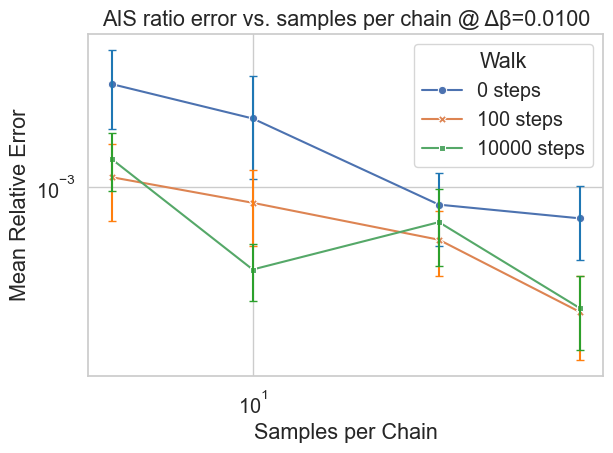

In [16]:
def test_trace_error_vs_samples_with_fixed_chains(
    dim=3,
    beta_prev=0.79,
    beta_curr=0.80,
    walk_durations=(0, 100, 10_000),
    sample_sizes=(5, 10, 25, 50),
    burn_steps=100,
    n_chains=10,
    n_trials=10,
    seed=42
):
    import numpy as _np
    import pandas as _pd
    import seaborn as _sns
    import matplotlib.pyplot as _plt
    from functools import partial as _partial

    _np.random.seed(seed)
    delta_beta = beta_curr - beta_prev

    # build 2×2 ring TN (Tr(ABCD))
    G = nx.Graph()
    G.add_edges_from([('A','B'), ('B','C'), ('C','D'), ('D','A')])
    mats = {n: _np.random.rand(dim,dim)+1e-6 for n in ('A','B','C','D')}
    idx_order = {'A':['i','j'],'B':['j','k'],'C':['k','l'],'D':['l','i']}
    tensors = {n:(mats[n], inds) for n,inds in idx_order.items()}
    tn = TensorNetwork(G, tensors)
    index_list = list(tn.index_dims)
    _col = tn.col_of
    _dims = tn.index_dims

    # local-bind hot paths
    _update = update_edge
    _eval   = evaluate_config
    _contract = _partial(contract_at_beta, G, tensors)

    # compute true ratio once
    Z_prev = _contract(beta_prev)
    Z_curr = _contract(beta_curr)
    true_ratio = Z_curr / Z_prev
    print(f">>> True single-step ratio: {true_ratio:.6f}  (Δβ={delta_beta:.4f})\n")

    results = {'SamplesPerChain':[], 'Walk':[], 'MeanErr':[], 'StdErr':[]}

    for walk in walk_durations:
        for S in sample_sizes:
            trial_errs = _np.empty(n_trials, dtype=float)

            # preallocate buffer for all weights in one trial
            total = n_chains * S
            weights = _np.empty(total, dtype=float)

            for t in range(n_trials):
                ptr = 0

                if walk == 0:
                    # for each chain: burn + S decorrelation steps
                    for _ in range(n_chains):
                        cfg = _np.random.randint(0, dim, size=(1,len(index_list)))
                        # burn-in
                        idxs_burn = _np.random.choice(index_list, size=burn_steps)
                        for idx in idxs_burn:
                            _update(tn, cfg, idx, beta=beta_prev)
                        # one update per sample
                        idxs_samp = _np.random.choice(index_list, size=S)
                        for idx in idxs_samp:
                            _update(tn, cfg, idx, beta=beta_prev)
                            psi = _eval(tn, cfg)[0]
                            weights[ptr] = psi ** delta_beta
                            ptr += 1

                else:
                    # batch-prepare random updates per chain
                    for _ in range(n_chains):
                        cfgs = _np.random.randint(0, dim, size=(S,len(index_list)))
                        # burn once
                        for idx in _np.random.choice(index_list, burn_steps):
                            _update(tn, cfgs, idx, beta=beta_prev)
                        # for each sample: walk then evaluate single row
                        for i in range(S):
                            for idx in _np.random.choice(index_list, walk):
                                _update(tn, cfgs, idx, beta=beta_prev)
                            psi = _eval(tn, cfgs[i:i+1])[0]
                            weights[ptr] = psi ** delta_beta
                            ptr += 1

                # finish trial
                rho_hat = weights.mean()
                trial_errs[t] = abs(rho_hat - true_ratio) / abs(true_ratio)

            m = trial_errs.mean()
            s = trial_errs.std(ddof=1) / (n_trials**0.5)
            print(f"Walk={walk:6d}, Samples/Chain={S:6d} → Error={m:.2%} ±{s:.2%}")

            results['SamplesPerChain'].append(S)
            results['Walk'].append(f"{walk} steps")
            results['MeanErr'].append(m)
            results['StdErr'].append(s)

    # final plot
    df = _pd.DataFrame(results)
    _sns.set_theme(style="whitegrid", font_scale=1.3)
    ax = _sns.lineplot(df, x="SamplesPerChain", y="MeanErr", hue="Walk",
                       style="Walk", markers=True, dashes=False)
    palette = _sns.color_palette("tab10")
    for i, walk in enumerate(walk_durations):
        sub = df[df['Walk']==f"{walk} steps"]
        _plt.errorbar(sub.SamplesPerChain, sub.MeanErr,
                      yerr=sub.StdErr, fmt='none',
                      capsize=3, color=palette[i])
    _plt.xscale('log'); _plt.yscale('log')
    _plt.xlabel("Samples per Chain"); _plt.ylabel("Mean Relative Error")
    _plt.title(f"AIS ratio error vs. samples per chain @ Δβ={delta_beta:.4f}")
    _plt.tight_layout(); _plt.show()

test_trace_error_vs_samples_with_fixed_chains()

In [ ]:
def test_trace_error_vs_deltabeta_diagdom(
    dim=3,
    betas=[(0.0, 1.0, n) for n in [10, 20, 50, 100, 200]],
    walk_steps=100,
    samples_per_chain=1000,   # unused here, left for symmetry
    n_chains=10,
    n_trials=10,
    seed=42
):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    np.random.seed(seed)

    # build 3×3 diagonally‐dominant TN
    G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
    tn = TensorNetwork(G, tensors)
    idxs = list(tn.index_dims)

    # helper: exact contraction at β
    def Z_at(beta):
        tempered = {
            name: (np.clip(T, 1e-30, None) ** beta, inds)
            for name, (T, inds) in tensors.items()
        }
        return contract_tensor_network(G, tempered)

    Z0 = Z_at(0.0)
    Z1 = Z_at(1.0)
    true_ratio = Z1 / Z0
    print(f">>> True single-step ratio Z(1)/Z(0) = {true_ratio:.6f}\n")

    records = []
    for β0, β1, nsteps in betas:
        dβ = (β1 - β0) / nsteps
        schedule = np.linspace(β0, β1, nsteps + 1)

        for trial in range(n_trials):
            # vectorized over chains:
            cfgs = np.random.randint(0, dim, size=(n_chains, len(idxs)))
            logw = np.zeros(n_chains, dtype=float)

            # loop over each sub-interval in schedule
            for b_prev, b_next in zip(schedule[:-1], schedule[1:]):
                # Gibbs‐mix all chains in one go
                for _ in range(walk_steps):
                    idx = np.random.choice(idxs)
                    update_edge(tn, cfgs, idx, beta=b_prev)

                # weight increment from this slice
                psi = evaluate_config(tn, cfgs)              
                logw += (b_next - b_prev) * np.log(psi + 1e-30)

            # one AIS single-step estimate per chain, then average
            w_final = np.exp(logw)                         
            rho_hat = w_final.mean()

            rel_err = abs(rho_hat - true_ratio) / abs(true_ratio)
            records.append({'db': dβ, 'trial': trial, 'rel_err': rel_err})

    df = pd.DataFrame(records)
    summary = (
        df
        .groupby('db')
        .rel_err
        .agg(['mean','sem'])
        .reset_index()
        .rename(columns={'mean':'MeanErr','sem':'StdErr'})
    )

    # plotting
    sns.set_theme(style="whitegrid", font_scale=1.3)
    plt.figure(figsize=(8,5))
    sns.lineplot(data=summary, x='db', y='MeanErr', marker='o')
    plt.errorbar(
        summary['db'], summary['MeanErr'],
        yerr=summary['StdErr'], fmt='none', capsize=3, color='black'
    )
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"$\Delta \beta$")
    plt.ylabel("Mean Relative Error")
    plt.title(f"AIS final error vs. Δβ on 3×3 Grid (walk={walk_steps})")
    plt.tight_layout()
    plt.show()

# run it
test_trace_error_vs_deltabeta_diagdom()